## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [1]:
from get_data import unpack
unpack('./facial-keypoints-data.zip')

ImportError: bad magic number in 'get_data': b'\x03\xf3\r\n'

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [163]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
import cv2
import os
import pandas as pd

def load_imgs_and_keypoints(dirname='facial-keypoints'):
    img_file = os.listdir('./data/images',)
    img_file = sorted(img_file)
    imgs_read = [cv2.imread('./data/images/{}'.format(x)) for x in img_file] #in BGR
    RGB_img = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs_read]
    imgs = [cv2.resize(x, (100,100)) for x in RGB_img ]
    imgs = array(imgs)
    
    x = [True if x%2==0 else False for x in range(0,28)]
    y = [not a for a in x]
    
    keypoints = pd.read_csv('./data/gt.csv')
    keypoints = keypoints.iloc[:,1:]
    for i in range(len(img_file)):
        keypoints.iloc[i,x] = keypoints.iloc[i,x]/imgs_read[i].shape[1]-0.5
        keypoints.iloc[i,y] = keypoints.iloc[i,y]/imgs_read[i].shape[0]-0.5
    keypoints = keypoints.values
     
    # Write your code for loading images and points here
    return imgs, keypoints

imgs, points = load_imgs_and_keypoints()

array([-0.30534351, -0.30534351, -0.01526718, -0.27099237,  0.14503817,
       -0.2519084 ,  0.27480916, -0.30152672, -0.24045802, -0.20610687,
       -0.17557252, -0.21374046, -0.08015267, -0.1870229 ,  0.11068702,
       -0.16793893,  0.15267176, -0.19847328,  0.23664122, -0.17938931,
        0.09541985,  0.04961832, -0.14885496,  0.16412214,  0.03435115,
        0.1870229 ,  0.14122137,  0.18320611])

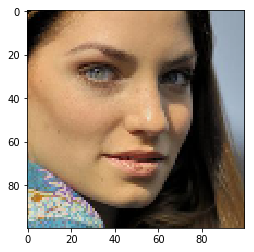

In [164]:
# Example of output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.imshow(imgs[0])
points[0]

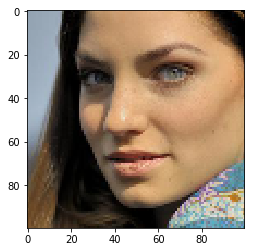

In [165]:
plt.imshow(cv2.flip(imgs[0],1))

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

In [166]:
x = [i  for i in range(28) if i%2==0]
y = [i  for i in range(28) if i%2!=0]

In [167]:
points[1]

array([-0.27659574, -0.28723404, -0.11702128, -0.30851064,  0.10638298,
       -0.29787234,  0.35106383, -0.23404255, -0.25531915, -0.21276596,
       -0.13829787, -0.22340426, -0.07446809, -0.20212766,  0.12765957,
       -0.18085106,  0.22340426, -0.18085106,  0.32978723, -0.14893617,
       -0.04255319, -0.0106383 , -0.17021277,  0.14893617, -0.0212766 ,
        0.20212766,  0.13829787,  0.19148936])

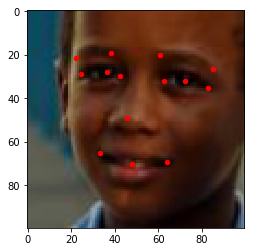

In [168]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    fig, ax = plt.subplots()
    im = ax.imshow(img)
    for i in range(len(points)//2):
        plt.plot((points[2*i]+0.5)*100, (points[2*i+1]+0.5)*100, 'o', color='red',markersize=4.5)
    
    plt.show()
    pass
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [169]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

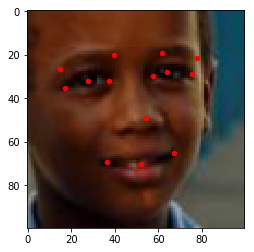

In [170]:
def flip_img(img, points):
    # Write your code for flipping here
    img=cv2.flip(img,1)
    new_points=np.copy(points)
    for ix in range(len(new_points)):
        if ix%2==0:
            new_points[ix]*=-1
    return img,new_points
f_img, f_points = flip_img(imgs[1], points[1])
visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [171]:
new_imgs,new_points=[],[]
for img,img_points in zip(imgs_train,points_train):
    f_img, f_points = flip_img(img, img_points)
    new_imgs.append(img)
    new_imgs.append(f_img)
    new_points.append(img_points)
    new_points.append(f_points)
    
aug_imgs_train=np.stack(new_imgs)
aug_points_train=np.stack(new_points)
aug_imgs_train.shape,aug_points_train.shape

((10800, 100, 100, 3), (10800, 28))

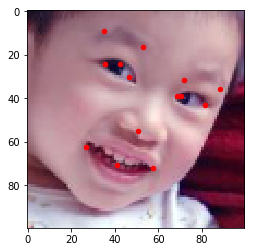

In [172]:
visualize_points(aug_imgs_train[11], aug_points_train[11])

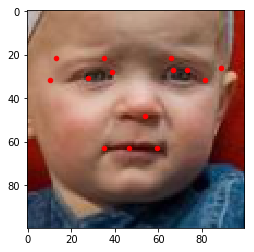

In [173]:
visualize_points(aug_imgs_train[41], aug_points_train[41])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [228]:
# #A VGG-16 Model

# from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
# from keras.layers import Dense, Flatten
# from keras.models import Model
# from keras import optimizers
# from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import img_to_array, load_img

# _input = Input((100,100,3)) 

# conv1  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(_input)
# batch1 = BatchNormalization()(conv1)
# conv2  = Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu")(batch1)
# batch2 = BatchNormalization()(conv2)
# dropout1 = Dropout(0.3)(batch2)
# pool1  = MaxPooling2D((2, 2))(dropout1)

# conv3  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(pool1)
# batch3 = BatchNormalization()(conv3)
# conv4  = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(batch3)
# batch4 = BatchNormalization()(conv4)
# dropout2 = Dropout(0.3)(batch4)
# pool2  = MaxPooling2D((2, 2))(dropout2)

# conv5  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(pool2)
# batch5 = BatchNormalization()(conv5)
# conv6  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(batch5)
# batch6 = BatchNormalization()(conv6)
# conv7  = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(batch6)
# batch7 = BatchNormalization()(conv7)
# dropout3 = Dropout(0.3)(batch7)
# pool3  = MaxPooling2D((2, 2))(dropout3)

# conv8  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool3)
# batch8 = BatchNormalization()(conv8)
# conv9  = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(batch8)
# batch9 = BatchNormalization()(conv9)
# conv10 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(batch9)
# batch10 = BatchNormalization()(conv10)
# dropout4 = Dropout(0.3)(batch10)
# pool4  = MaxPooling2D((2, 2))(dropout4)

# conv11 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(pool4)
# batch11 = BatchNormalization()(conv11)
# conv12 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(batch11)
# batch12 = BatchNormalization()(conv12)
# conv13 = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(batch12)
# batch13 = BatchNormalization()(conv13)
# dropout5 = Dropout(0.3)(batch13)
# pool5  = MaxPooling2D((2, 2))(dropout5)

# flat   = Flatten()(pool5)
# dense1 = Dense(1024, activation="relu")(flat)
# dense2 = Dense(512, activation="relu")(dense1)
# output = Dense(28)(dense2)

# vgg16_model  = Model(inputs=_input, outputs=output)

In [233]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten, MaxPool2D,
    Dense, Dropout, Activation, BatchNormalization
)

model = Sequential()
# Define here your model
model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", input_shape=(100,100,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))

model.add(Dense(28))


In [235]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
batch_normalization_76 (Batc (None, 100, 100, 16)      64        
_________________________________________________________________
activation_37 (Activation)   (None, 100, 100, 16)      0         
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 50, 50, 32)        4640      
_________________________________________________________________
batch_normalization_77 (Batc (None, 50, 50, 32)        128       
_________________________________________________________________
activation_38 (Activation)   (None, 50, 50, 32)        0         
__________

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [236]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD, Adam

model.compile(optimizer=Adam(lr=0.0003,decay=4e-5), loss='mse')

# Choose optimizer, compile model and run training

In [237]:
history = model.fit(aug_imgs_train,aug_points_train,epochs=500,batch_size=32,shuffle=True,
          validation_data=(imgs_val, points_val),verbose = 2)

Train on 10800 samples, validate on 600 samples
Epoch 1/500
 - 87s - loss: 0.3666 - val_loss: 0.0528
Epoch 2/500
 - 78s - loss: 0.1557 - val_loss: 0.0242
Epoch 3/500
 - 79s - loss: 0.0866 - val_loss: 0.0256
Epoch 4/500
 - 76s - loss: 0.0470 - val_loss: 0.0220
Epoch 5/500
 - 78s - loss: 0.0334 - val_loss: 0.0195
Epoch 6/500
 - 78s - loss: 0.0279 - val_loss: 0.0168
Epoch 7/500
 - 79s - loss: 0.0247 - val_loss: 0.0169
Epoch 8/500
 - 77s - loss: 0.0228 - val_loss: 0.0207
Epoch 9/500
 - 77s - loss: 0.0215 - val_loss: 0.0197
Epoch 10/500
 - 75s - loss: 0.0200 - val_loss: 0.0192
Epoch 11/500
 - 75s - loss: 0.0193 - val_loss: 0.0184
Epoch 12/500
 - 76s - loss: 0.0188 - val_loss: 0.0211
Epoch 13/500
 - 73s - loss: 0.0182 - val_loss: 0.0176
Epoch 14/500
 - 72s - loss: 0.0172 - val_loss: 0.0202
Epoch 15/500
 - 72s - loss: 0.0165 - val_loss: 0.0188
Epoch 16/500
 - 73s - loss: 0.0157 - val_loss: 0.0180
Epoch 17/500
 - 76s - loss: 0.0148 - val_loss: 0.0193
Epoch 18/500
 - 76s - loss: 0.0143 - val_lo

KeyboardInterrupt: 

In [192]:
history.history.keys()

dict_keys(['val_loss', 'loss'])

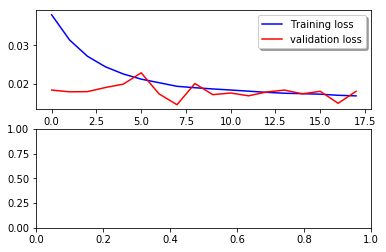

In [195]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

In [196]:
model.save_weights('keypoints_regressor_trained_weights2.h5')

In [197]:
# Example of output
predicted_keypoints=model.predict(imgs_val)
print(predicted_keypoints[0:5,:]) #check that outputs are different

[[ 6.54160306e-02 -2.72587925e-01  4.71589230e-02 -2.85126805e-01
  -6.34028902e-03 -2.90032059e-01 -7.28523657e-02 -2.83711493e-01
   5.94058000e-02 -1.81923419e-01  4.72110808e-02 -1.94195837e-01
   2.90829428e-02 -1.89008474e-01 -2.40809750e-02 -1.90173626e-01
  -4.52723987e-02 -1.98877722e-01 -5.89447394e-02 -1.99673280e-01
   3.85155641e-02  1.44819263e-02  3.21280286e-02  1.78849176e-01
   1.43344812e-02  1.90620452e-01 -3.50621119e-02  1.81844637e-01]
 [-4.92898785e-02 -2.68525869e-01  3.47806024e-03 -2.76380777e-01
   4.82241698e-02 -2.77159750e-01  1.15327902e-01 -2.76168227e-01
  -3.57501544e-02 -1.84008881e-01 -2.38009170e-02 -1.87783197e-01
  -9.37541574e-03 -1.84735015e-01  5.00697754e-02 -1.83698222e-01
   7.36617148e-02 -1.93636432e-01  1.00525945e-01 -1.88006595e-01
  -2.08466370e-02  1.77338906e-02 -5.11745885e-02  1.72447160e-01
  -2.17088461e-02  1.88015923e-01  2.44200360e-02  1.63541228e-01]
 [-1.16950735e-01 -2.65243709e-01 -4.69244905e-02 -2.69361705e-01
   1.390

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

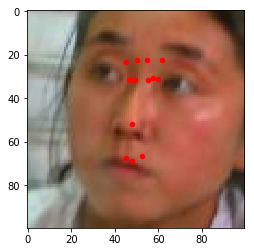

In [198]:
visualize_points(imgs_val[1],predicted_keypoints[1]) #visualize one image

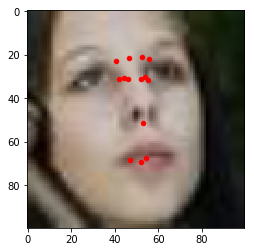

In [206]:
visualize_points(imgs_val[6],predicted_keypoints[6]) #visualize one image


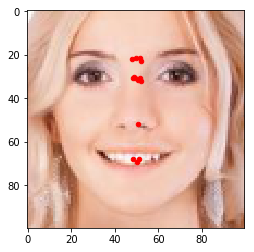

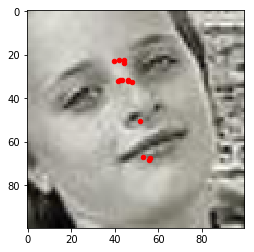

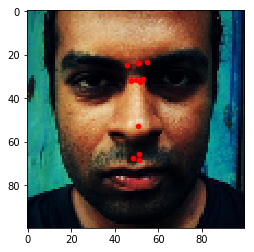

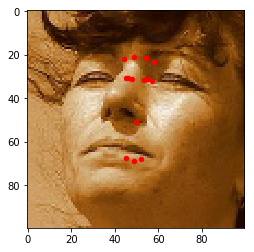

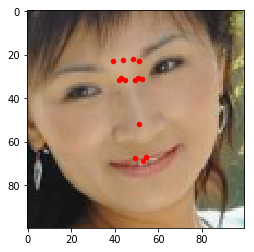

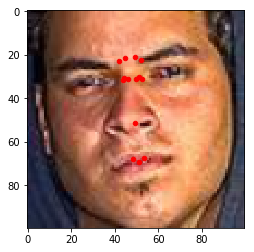

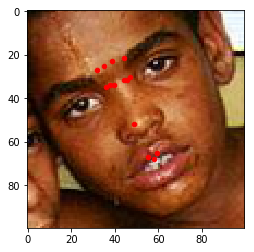

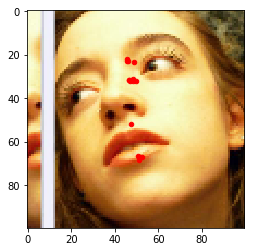

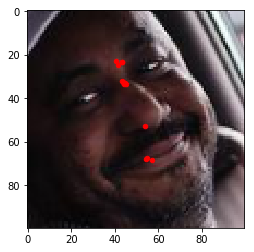

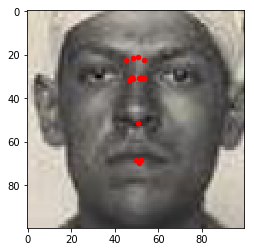

In [207]:
for i in range(10):
    ix=np.random.choice(range(imgs_val.shape[0]))
    visualize_points(imgs_val[ix],predicted_keypoints[ix])